# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from datetime import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

In [2]:
# Загрузка данных
df = pd.read_excel('data/train.xlsx', index_col='dt')
df = df.asfreq('W-MON')  # Частота данных — еженедельно
df.head()

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300


In [3]:
df.shape

(400, 1)

In [4]:
df

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300
...,...
2022-08-01,47500
2022-08-08,49000
2022-08-15,47500


In [5]:
def check_stationary(column):
    p_value = adfuller(column)[1]
    print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.')
    if p_value > 0.05:
        print(f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной. Ряд нестационарен')
    else:
        print(f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной. Ряд можно называть стационарным')

In [6]:
check_stationary(df['Цена на арматуру'])

Полученный уровень значимости (p-value): 0.32.
0.32 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной. Ряд нестационарен


<Axes: xlabel='dt'>

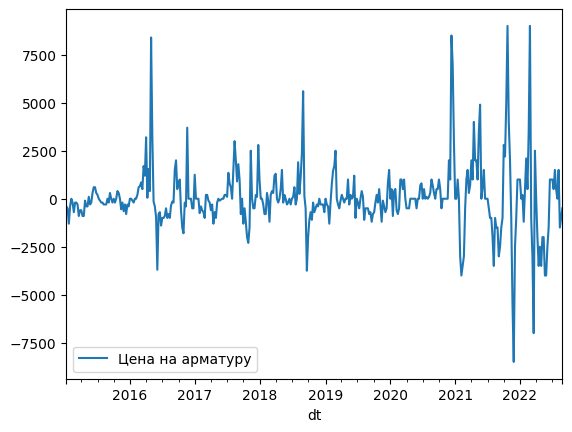

In [7]:
df_train_diff = df.diff().dropna()
df_train_diff.plot()

In [8]:
df_train_diff

,Цена на арматуру
dt,
2015-01-12,-400.0
2015-01-19,-500.0
2015-01-26,-1300.0
2015-02-02,-400.0
2015-02-09,0.0
...,...
2022-08-01,0.0
2022-08-08,1500.0
2022-08-15,-1500.0


In [9]:
check_stationary(df_train_diff['Цена на арматуру'])

Полученный уровень значимости (p-value): 0.0.
0.0 < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной. Ряд можно называть стационарным


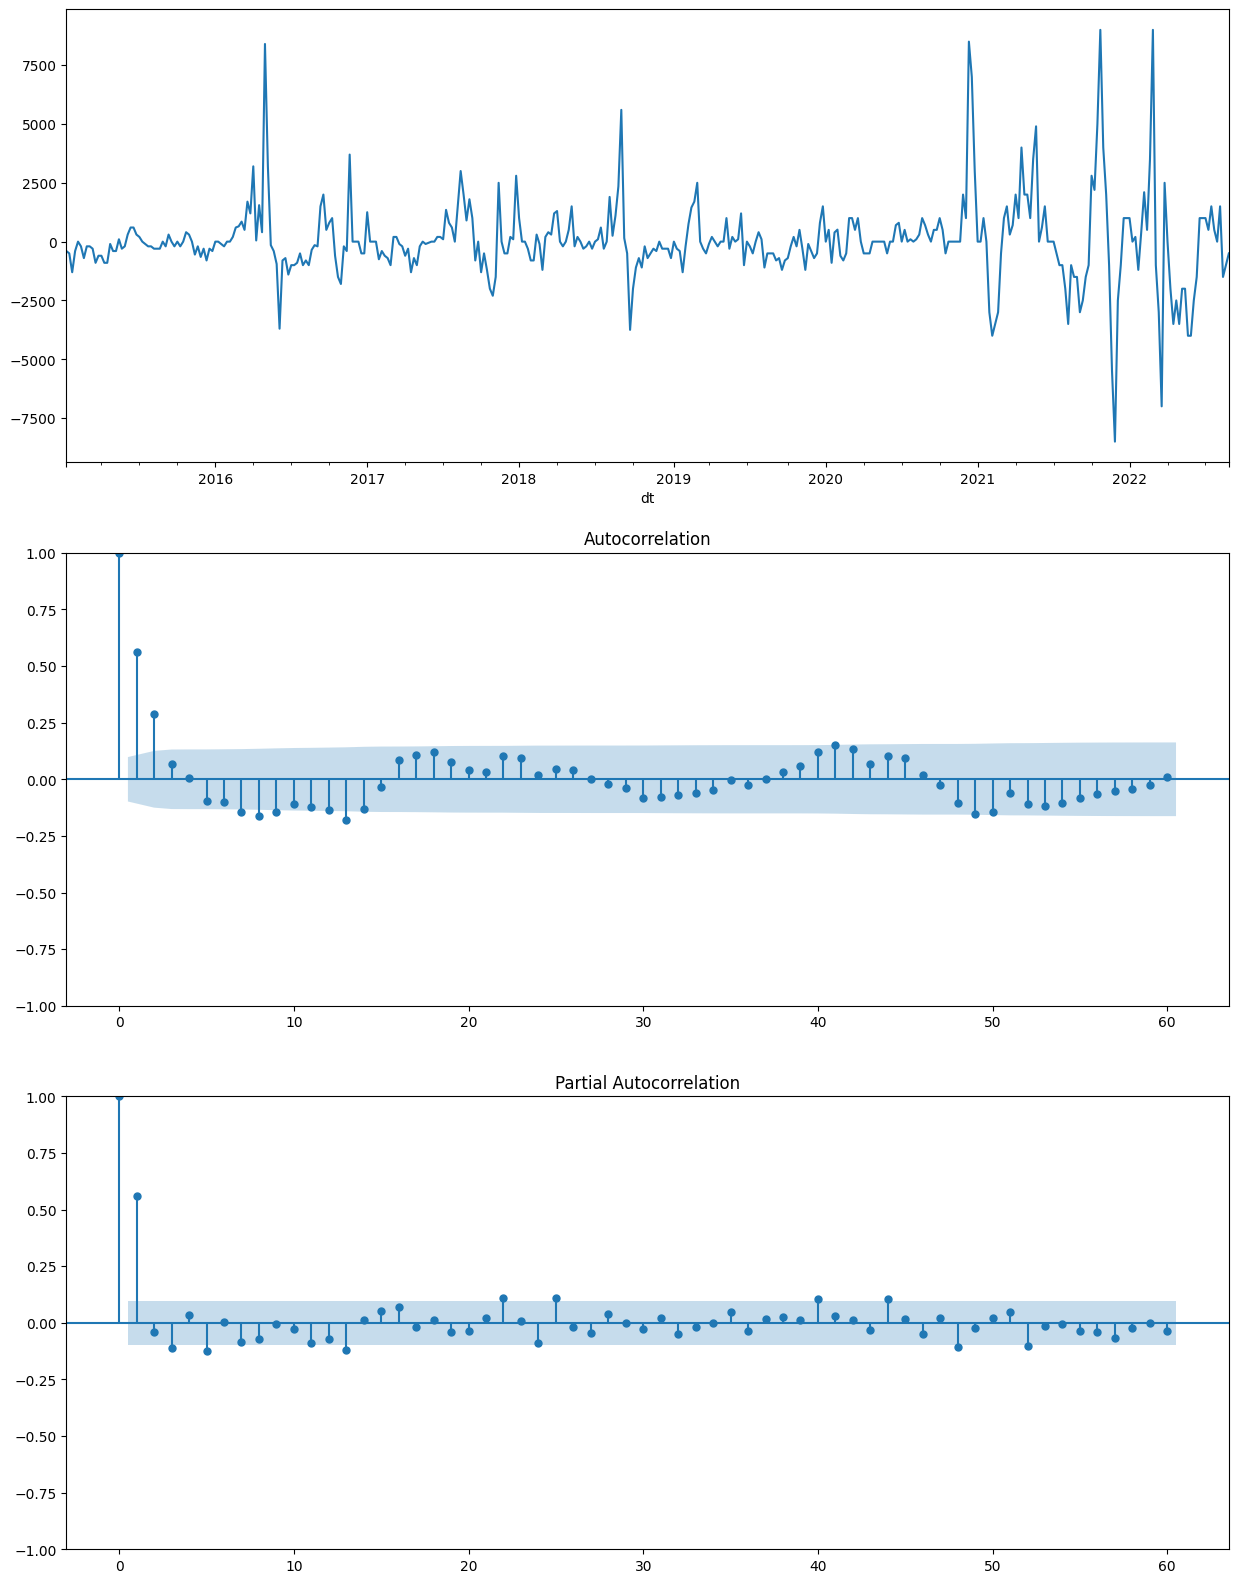

In [10]:
# вывод кореллограмм для выявления параметров для будущей модели
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
df_train_diff['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_train_diff['Цена на арматуру'], lags=60, ax=ax[1])
plot_pacf(df_train_diff['Цена на арматуру'], lags=60, ax=ax[2]);

In [11]:
# разделение данных
test_size = int(len(df) * 0.2)
train, test = df_train_diff.iloc[:-test_size], df_train_diff.iloc[-test_size:]

# Модели

## SARIMAX

In [12]:
# отключаем безвредные предупреждения
warnings.filterwarnings("ignore") 
  
# рассчёт лучших значений для ARIMA 
stepwise_fit = auto_arima(df_train_diff['Цена на арматуру'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7185.272, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=6894.012, Time=1.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=7183.298, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=6992.349, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=6846.427, Time=3.32 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=6799.659, Time=8.86 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.44 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=13.11 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=5.46 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=6983.657, Time=6.05 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=6822.200, Time=9.59 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=12.11 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=6843

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  399
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 12)   Log Likelihood               -3393.830
Date:                              Wed, 26 Mar 2025   AIC                           6799.659
Time:                                      03:43:44   BIC                           6823.410
Sample:                                  01-12-2015   HQIC                          6809.077
                                       - 08-29-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.5446     16.069      0.594      0.553     -21.951      41.040
ar.L1          0.5462      0.027     20.528      0.000       0.494       0.598
ar.S.L12       0.1262      0.116      1.088      0.277      -0.101       0.354
ar.S.L24       0.0685      0.087      0.790      0.430      -0.102       0.239
ma.S.L12      -0.8718      0.124     -7.029      0.000      -1.115      -0.629
sigma2      2.916e+06   1.61e+05     18.069      0.000     2.6e+06    3.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):              1008.74
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
model = SARIMAX(train, 
				order = (3, 0, 2), 
				seasonal_order =(0, 1, 1, 12)) 

result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Цена на арматуру   No. Observations:                  319
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2593.955
Date:                              Wed, 26 Mar 2025   AIC                           5201.911
Time:                                      03:43:49   BIC                           5227.999
Sample:                                  01-12-2015   HQIC                          5212.343
                                       - 02-15-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4776      0.099     24.904      0.000       2.283       2.673
ar.L2         -2.0088      0.142    -14.123      0.000      -2.288      -1.730
ar.L3          0.5305      0.047     11.198      0.000       0.438       0.623
ma.L1         -1.9516      0.119    -16.357      0.000      -2.185      -1.718
ma.L2          0.9516      0.119      7.998      0.000       0.718       1.185
ma.S.L12      -0.9433      0.056    -16.808      0.000      -1.053      -0.833
sigma2      1.187e+06   1.49e-07   7.97e+12      0.000    1.19e+06    1.19e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):              4886.84
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             2.88
Prob(H) (two-sided):                  0.47   Kurtosis:                        21.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+29. Standard errors may be unstable.
"""

In [14]:
# предсказывание данных
forecast = result.get_forecast(steps=len(test))
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

In [ ]:
# оценка модели по метрикам
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)
mape = mean_absolute_percentage_error(test, pred)
r2 = r2_score(test, pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 2073.61
MAPE: 143467914761300096.00%
R²: -0.0291


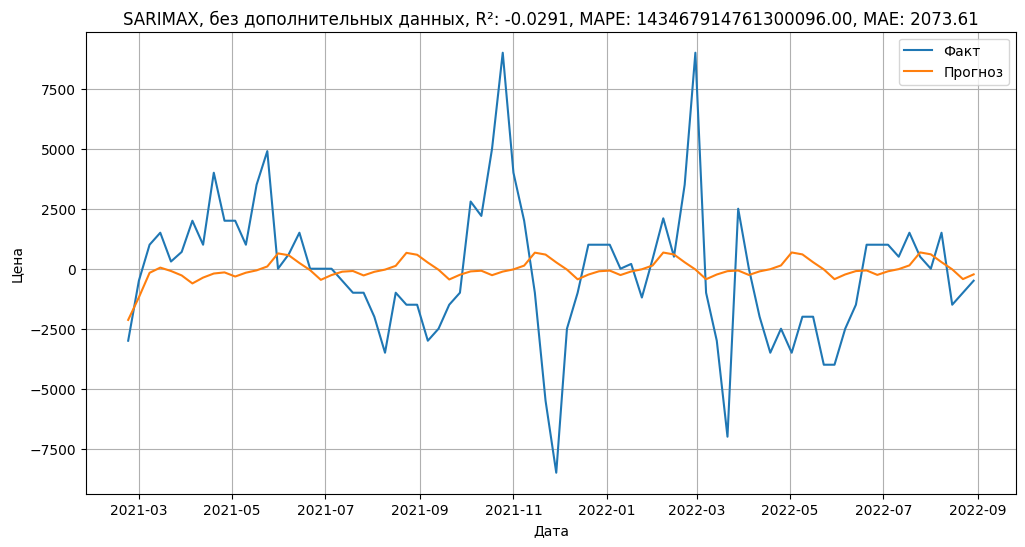

In [16]:
# визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Факт")
plt.plot(test.index, pred, label="Прогноз")
plt.title(f"SARIMAX, без дополнительных данных, R²: {r2:.4f}, MAPE: {mape:.2f}, MAE: {mae:.2f}")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()